## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [189]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [190]:
# Opening JSON file 


f = open('complaints-2021-05-14_08_16.json')

  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [191]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [192]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [193]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_description', '_source.product':'tag'}, inplace=True)


In [194]:
#new column names check 
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_description',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [195]:
num_blanks = (df['complaints_description'] == '').sum()

print(f"Number of blanks in 'complaints' column: {num_blanks}")

Number of blanks in 'complaints' column: 57241


In [196]:
#Assign nan in place of blanks in the complaints column

# Replace blanks with NaN
df['complaints_description'] = df['complaints_description'].replace('', np.nan)


In [197]:
num_blanks = (df['complaints_description'] == '').sum()

print(f"Number of blanks in 'complaints' column: {num_blanks}")

Number of blanks in 'complaints' column: 0


In [198]:
#Remove all rows where complaints column is nan
print(f"shape before removal of rows having nan: {df.shape}")

df = df.dropna(subset=['complaints_description'])

print(f"shape after removal of rows having nan: {df.shape}")

shape before removal of rows having nan: (78313, 22)
shape after removal of rows having nan: (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [199]:
# Write your function here to clean the text and remove all the unnecessary elements.

# Function to clean text
def clean_text(text):
    text = text.lower()  # Make lowercase
    
    text = re.sub(r'\bx{2,}\b', '', text) # Remove all words with more than one x as these area masked ones and not useful for analysis
   
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\b\w*\d\w*\b', '', text)  # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    return text

# Apply the clean_text function to the 'complaints_description' column
df['complaints_description'] = df['complaints_description'].apply(clean_text)

print("DataFrame after cleaning 'complaints' column:")
df.head()


DataFrame after cleaning 'complaints' column:


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,complaints_description,_source.sub_issue,_source.consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an

In [200]:
#Cheking full 'complaints_description', 'tag' column
filtered_df = df[['complaints_description', 'tag']]
pd.set_option('display.max_colwidth', None)
print(filtered_df.head())

In [201]:
#Write your function to Lemmatize the texts


from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import time




# Download required nltk data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# Download required nltk data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


# Function to lemmatize text
def lemmatize_text(text):
    
    # Tokenize text
    tokens = word_tokenize(text)
    # Get POS tags for the tokens
    tagged_tokens = nltk.pos_tag(tokens)
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize tokens with POS tags
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag)) for token, pos_tag in tagged_tokens]
    # Join lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text



# Function to map nltk POS tags to wordnet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
df['complaints'] = df[['complaints_description']]  
current_time = time.ctime()
print("Lemmmatize starts...:"+current_time)    
# Apply the lemmatize_text function to the 'complaints' column

df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized_complaints':df['complaints'].apply(lemmatize_text)})
#df_lemmantized = df['complaints'].apply(lemmatize_text)
current_time = time.ctime()
print("Lemmmatize ends...:"+current_time)  
    

[nltk_data] Downloading package punkt to /Users/Himanshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Himanshu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Himanshu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/Himanshu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Himanshu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Himanshu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Lemmmatize starts...:Sat May 25 17:20:06 2024
Lemmmatize ends...:Sat May 25 17:21:36 2024


In [202]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean 

,complaints,lemmatized_complaints
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact and be refer to chase bank i then immediately contacted chase bank within no more than of get the notification on the screen and i be tell by the chase representative i speak with that my application be deny but she could not state why i ask for more information about the offer and she explain that even if i have be approve the credit offer only get apply after the first account statement and could not be use to purchase t

In [203]:
#Write your function to extract the POS tags 



In [204]:



def pos_tag(text):
    
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    return [tag for _, tag in tagged_tokens]


# Create a new column with nouns (NN) only
df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaints'].apply(
    lambda text: ' '.join([token for token, pos in nltk.pos_tag(word_tokenize(text)) if pos == "NN"]))


df_clean # View the cleaned dataframe

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact and be refer to chase bank i then immediately contacted chase bank within no 

In [205]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact and be refer to chase bank i then immediately contacted chase bank within no 

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




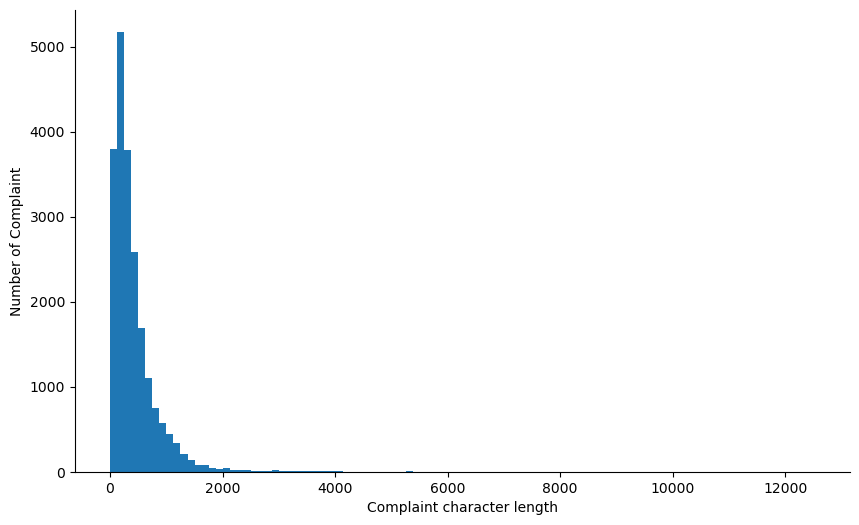

In [206]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

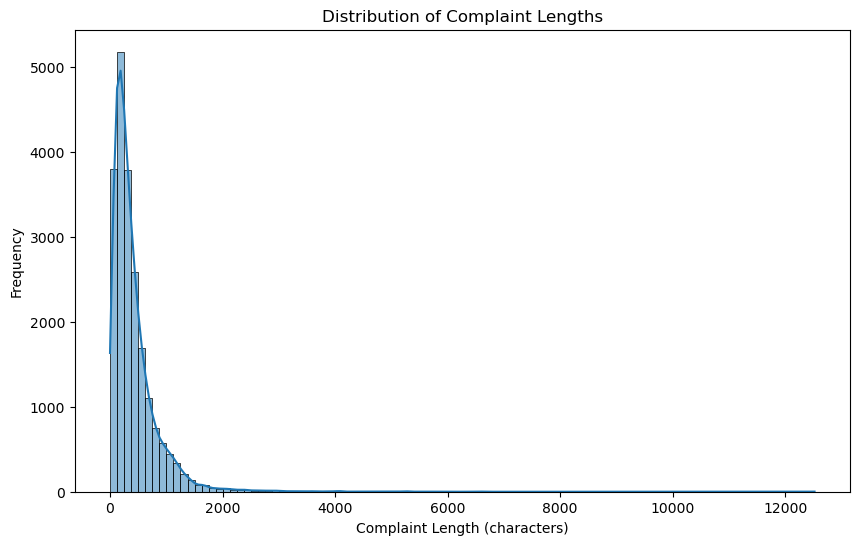

In [207]:
# Calculate the length of each complaint
df_clean['complaint_length'] = df_clean['complaint_POS_removed'].apply(len)

# Plot the histogram of complaint lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=100, kde=True)
plt.title('Distribution of Complaint Lengths')
plt.xlabel('Complaint Length (characters)')
plt.ylabel('Frequency')
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

In [208]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

# from wordcloud import WordCloud, STOPWORDS
# wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
# wordcloud.generate(str(df_clean['complaint_POS_removed']))
# plt.figure(figsize=(12,12))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()



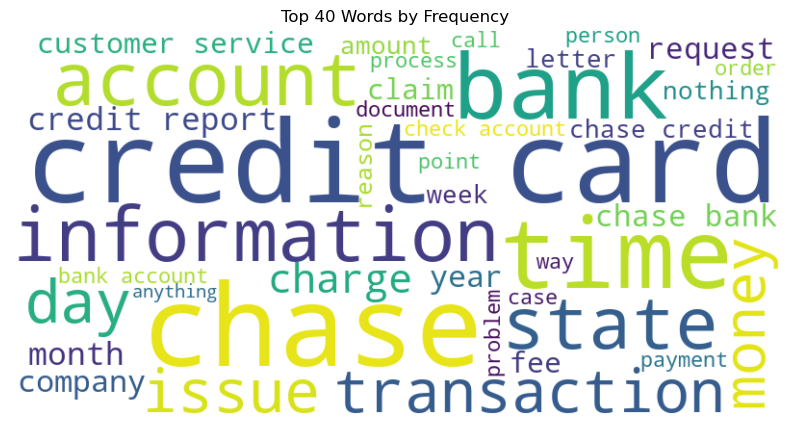

In [209]:
# Combine all complaints into one text
all_text = ' '.join(df_clean['complaint_POS_removed'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white',stopwords=set(STOPWORDS)).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency')
plt.show()

In [210]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [211]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaints'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram
    

        Unigram  Frequency
0             i     100562
1         chase      49428
2       account      47313
3        credit      34130
4          card      29248
5          bank      28510
6       payment      21168
7          time      16048
8        charge      14769
9           day      12979
10        check      12872
11        money      11961
12         call      11757
13         loan      11004
14        state       9928
15       letter       9674
16  information       9654
17       report       9028
18  transaction       8651
19          fee       8637
20       number       8625
21        month       8508
22       amount       8389
23         year       8301
24     mortgage       8191
25     customer       8163
26      service       7830
27        claim       7799
28      balance       7752
29        phone       7716


<Figure size 1000x600 with 0 Axes>

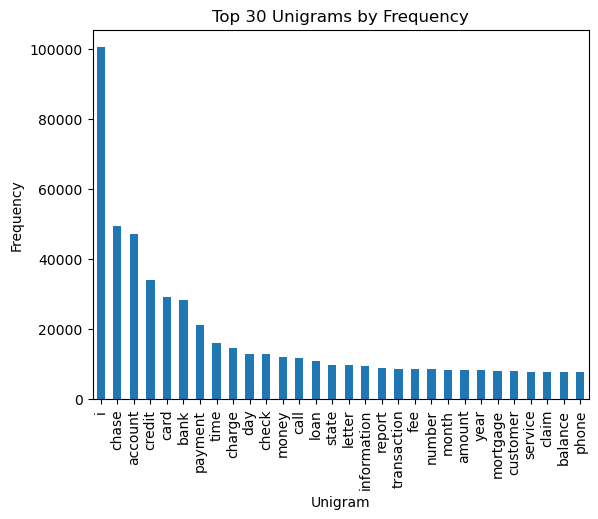

In [212]:

from collections import Counter

# Tokenize text to get unigrams
tokens = word_tokenize(all_text)

# Get the frequency of each unigram
unigram_freq = Counter(tokens)

# Get the top 30 unigrams by frequency
top_30_unigrams = unigram_freq.most_common(30)

# Convert to DataFrame for better visualization
top_30_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

# Print the top 30 unigrams
print(top_30_unigrams_df)

# Plot the top 30 unigrams
plt.figure(figsize=(10, 6))
top_30_unigrams_df.set_index('Unigram').plot(kind='bar', legend=False)
plt.title('Top 30 Unigrams by Frequency')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [213]:
#Print the top 10 words in the unigram frequency
unigram_freq.most_common(10)

[('i', 100562),
 ('chase', 49428),
 ('account', 47313),
 ('credit', 34130),
 ('card', 29248),
 ('bank', 28510),
 ('payment', 21168),
 ('time', 16048),
 ('charge', 14769),
 ('day', 12979)]

                 Bigram  Frequency
0        (credit, card)      12756
1            (i, chase)       5405
2          (account, i)       4739
3                (i, i)       4017
4      (credit, report)       3960
5             (card, i)       3321
6         (chase, bank)       3294
7   (customer, service)       3081
8       (chase, credit)       3054
9          (i, account)       3051
10          (i, credit)       2813
11            (i, call)       2753
12     (check, account)       2687
13            (i, bank)       2667
14      (bank, account)       2621
15           (chase, i)       2387
16     (account, chase)       2358
17     (chase, account)       2306
18         (i, payment)       2147
19         (payment, i)       1983
20   (account, account)       1887
21            (i, card)       1700
22        (call, chase)       1699
23        (phone, call)       1634
24            (time, i)       1630
25        (debit, card)       1571
26          (i, charge)       1543
27      (credit, sco

<Figure size 1500x2000 with 0 Axes>

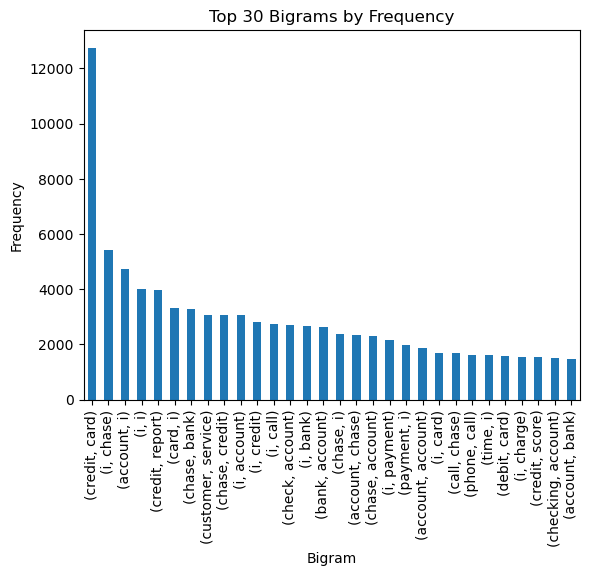

In [214]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

from nltk.util import bigrams

bigrams_tokens = list(bigrams(tokens))

# Get the frequency of each bigram
bigram_freq = Counter(bigrams_tokens)

# Get the top 30 bigrams by frequency
top_30_bigrams = bigram_freq.most_common(30)

# Convert to DataFrame for better visualization
top_30_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

# Print the top 30 bigrams
print(top_30_bigrams_df)

# Plot the top 30 bigrams
plt.figure(figsize=(15, 20))
top_30_bigrams_df.set_index('Bigram').plot(kind='bar', legend=False)
plt.title('Top 30 Bigrams by Frequency')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [215]:
#Print the top 10 words in the bigram frequency
bigram_freq.most_common(10)

[(('credit', 'card'), 12756),
 (('i', 'chase'), 5405),
 (('account', 'i'), 4739),
 (('i', 'i'), 4017),
 (('credit', 'report'), 3960),
 (('card', 'i'), 3321),
 (('chase', 'bank'), 3294),
 (('customer', 'service'), 3081),
 (('chase', 'credit'), 3054),
 (('i', 'account'), 3051)]

Top 30 Trigrams by Frequency:
                        Trigram  Frequency
0         (chase, credit, card)       2132
1             (i, credit, card)       1210
2             (credit, card, i)       1120
3       (credit, card, company)        979
4       (credit, card, account)        974
5              (i, call, chase)        648
6         (credit, card, chase)        587
7     (inquiry, credit, report)        478
8        (i, customer, service)        474
9        (credit, card, credit)        404
10             (i, chase, bank)        393
11       (charge, credit, card)        387
12  (credit, reporting, agency)        386
13          (account, i, chase)        379
14   (chase, customer, service)        371
15           (i, chase, credit)        371
16      (account, credit, card)        349
17         (bank, credit, card)        347
18         (credit, card, bank)        329
19     (credit, reporting, act)        329
20              (i, account, i)        328
21     (credit, report, 

<Figure size 1200x800 with 0 Axes>

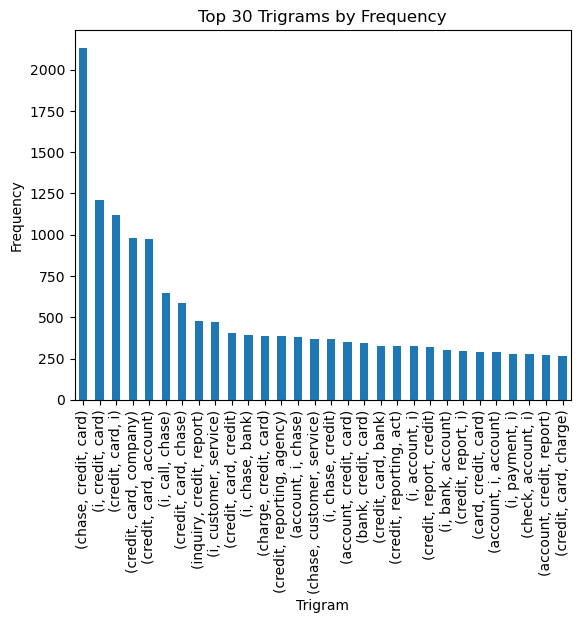

In [216]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

from nltk.util import trigrams

trigrams_tokens = list(trigrams(tokens))

# Get the frequency of each trigram
trigram_freq = Counter(trigrams_tokens)

# Get the top 30 trigrams by frequency
top_30_trigrams = trigram_freq.most_common(30)

# Convert to DataFrame for better visualization
top_30_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

# Print the top 30 trigrams
print("Top 30 Trigrams by Frequency:")
print(top_30_trigrams_df)

# Plot the top 30 trigrams
plt.figure(figsize=(12, 8))
top_30_trigrams_df.set_index('Trigram').plot(kind='bar', legend=False)
plt.title('Top 30 Trigrams by Frequency')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [217]:
#Print the top 10 words in the trigram frequency
trigram_freq.most_common(10)

[(('chase', 'credit', 'card'), 2132),
 (('i', 'credit', 'card'), 1210),
 (('credit', 'card', 'i'), 1120),
 (('credit', 'card', 'company'), 979),
 (('credit', 'card', 'account'), 974),
 (('i', 'call', 'chase'), 648),
 (('credit', 'card', 'chase'), 587),
 (('inquiry', 'credit', 'report'), 478),
 (('i', 'customer', 'service'), 474),
 (('credit', 'card', 'credit'), 404)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [218]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

# Already cleaned in the function def clean_textxx used earlier in this notebook, commented code here is just the copy for ref



# # Function to remove unwanted patterns
# def clean_textxx(text):
#     # Remove specific unwanted patterns
#     text = re.sub(r'\bx{2,}\b', '', text)
#    # text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers
#    # text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
#     return text

# # Apply the clean_text function to the 'Complaint_clean' column
# df['Complaint_clean'] = df['Complaint_clean'].apply(clean_text)

# print("DataFrame after cleaning 'Complaint_clean' column:")
# df.head()



In [219]:
#All masked texts has been removed ; earier removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,157,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me,i card agent upgrade date agent information order account change date consent recording agent,93,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [220]:
#Write your code here to initialise the TfidfVectorizer 
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [221]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Fit and transform the text data to obtain the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])

# Extract the non-zero elements from the TF-IDF matrix
tfidf_nonzero = tfidf_matrix.nonzero()
tfidf_scores = tfidf_matrix.data

# Create tuples of (complaint_id, token_id, tf-idf score)
document_term_tuples = [(doc_id, token_id, tfidf_scores[idx]) for idx, (doc_id, token_id) in enumerate(zip(*tfidf_nonzero))]

# Display the document-term tuples
print("Document Term Tuples (complaint_id, token_id, tf-idf score):")
for tuple_ in document_term_tuples:
    print(tuple_)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(20454, 24, 0.060945902729967485)
(20454, 5541, 0.23177957256854603)
(20454, 3680, 0.07613011232836124)
(20454, 4151, 0.0650238125949133)
(20454, 4651, 0.07312672379841735)
(20454, 5556, 0.07396236624246519)
(20454, 393, 0.08682589356656494)
(20454, 134, 0.06629975945233323)
(20454, 7063, 0.06301314879536508)
(20454, 6346, 0.10349779621962066)
(20454, 5106, 0.12265578999187726)
(20454, 7169, 0.06475026094800376)
(20454, 112, 0.09326103461235792)
(20454, 4649, 0.04844547181650478)
(20454, 6548, 0.04383545409830579)
(20454, 98, 0.04243987474613192)
(20454, 7366, 0.05269740605551722)
(20454, 4695, 0.07958946665294273)
(20454, 201, 0.04179134956793136)
(20454, 2192, 0.12115479079001755)
(20454, 4130, 0.5005252284377535)
(20454, 5375, 0.08554882725293164)
(20454, 2157, 0.03965922090767334)
(20454, 2527, 0.04829552371315676)
(20454, 647, 0.04718440467387238)
(20454, 3195, 0.04176144990867217)
(20454, 5511, 0.04776933283765923)
(20454, 2351, 0.13999350138115413)
(20454, 5014, 0.04033137300532

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [222]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [223]:
#Load your nmf_model with the n_components i.e 5
#num_topics = #write the value you want to test out

#keep the random_state =40
#nmf_model = #write your code here

from sklearn.decomposition import NMF

# Set the number of topics
num_topics = 5  # You can adjust this number as needed

# Initialize the NMF model
nmf_model = NMF(n_components=num_topics, random_state=40)

# Fit the NMF model to the TF-IDF matrix
nmf_model.fit(tfidf_matrix)

# Display the topics and the top words in each topic
for index, topic in enumerate(nmf_model.components_):
    print(f"Topic #{index + 1}:")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]]) 


Topic #1:
['claim', 'transfer', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']
Topic #2:
['year', 'letter', 'application', 'debt', 'information', 'limit', 'bureau', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']
Topic #3:
['mortgage', 'year', 'account', 'credit', 'chase', 'date', 'auto', 'pay', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']
Topic #4:
['company', 'statement', 'refund', 'time', 'service', 'claim', 'fraud', 'purchase', 'merchant', 'dispute', 'fee', 'transaction', 'chase', 'card', 'charge']
Topic #5:
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']


In [ ]:
# 0 Bank Account services
# 1 Credit card or prepaid card
# 2 Others
# 3 Theft/Dispute Reporting
# 4 Mortgage/Loan

In [224]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

NameError: name 'dtm' is not defined

In [ ]:
#Print the Top15 words for each of the topics


In [225]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4


topic_results = nmf_model.transform(tfidf_matrix)
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [226]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [227]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,157,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me,i card agent upgrade date agent information order account change date consent recording agent,93,i card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did

In [228]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,157,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank close my account never pay me my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay me my money my grand son call chase time they tell him i should call not him to verify the check owner he be out the country most the time date happen check number claim number be with chase,son deposit chase account fund bank account money son check money bank refuse money son call chase time check owner country time date check number claim number chase,165,son deposit chase account fund bank account money son check money bank refuse money son call chase time check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserv

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [229]:
#Create the dictionary of Topic names and Topics

# 0 Bank Account services
# 1 Credit card or prepaid card
# 2 Others
# 3 Theft/Dispute Reporting
# 4 Mortgage/Loan


Topic_names = {0:'Bank Account services', 1:'Credit card or prepaid card', 2:'Others', 3:'Theft/Dispute Reporting', 4:'Mortgage/Loan'}

#Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}


#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)





# Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


/var/folders/tr/cm_6t8c13wg214jfjd0sfd9c0000gn/T/ipykernel_43133/3617914424.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [230]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,157,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,Bank Account services
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me,i card agent upgrade date agent information order account change date consent recording agent,93,i card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [231]:
# #Create the dictionary again of Topic names and Topics

# Topic_names = {   }

Topic_names = {'Bank Account services':0, 'Credit card or prepaid card':1, 'Others':2, 'Theft/Dispute Reporting':3, 'Mortgage/Loan':4}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/var/folders/tr/cm_6t8c13wg214jfjd0sfd9c0000gn/T/ipykernel_43133/3519960855.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [232]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name be and i appreciate it if you could help me put a stop to chase bank cardmember service in i write to chase ask for debt verification and what they send me a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from them attempt to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,157,morning name stop bank cardmember service ask debt verification statement i bank debt mail month debt i right information consumer chase account advance help,0
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgrade my card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give me the wrong information in order to upgrade the account change my anniversary date from to without my consent have the recording of the agent who be mislead me,i card agent upgrade date agent information order account change date consent recording agent,93,i card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did

In [234]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

# Create the training_data DataFrame with only "complaints_description" and "Topic" columns
training_data = df_clean[['complaints', 'Topic']]


In [235]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,0
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,0
15,can you please remove inquiry,1
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additiona

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [237]:

#Write your code to get the Vector count

from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [246]:
# Split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=40)
r

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [247]:
# Write your code here to build any 3 models and evaluate them using the required metrics

In [248]:
#required imports for model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

1. Logistic Regression

In [249]:
#Logistic Regression model
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels

2. Decision Tree

In [250]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels

3. Random Forest Classifier model

In [251]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels

4. Gaussian Naive Bayes


In [252]:

nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/Himanshu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### Infering the best model